In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import wordcloud
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [43]:
nltk.download('stopwords')
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [57]:
spam_data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='iso-8859-1')
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [58]:
# Remove unnecessary columns
spam_data = spam_data[['v1', 'v2']]

In [59]:
# Rename columns
spam_data.rename(columns = {'v1': 'Target', 'v2': 'Text'}, inplace = True)

In [60]:
spam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [61]:
spam_data.describe()

,Target,Text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [62]:
spam_data.isnull().sum()

Target    0
Text      0
dtype: int64

In [63]:
print(f"There are {spam_data.duplicated().sum()} duplicate texts.")

There are 403 duplicate texts.


In [64]:
spam_data.drop_duplicates(inplace = True)

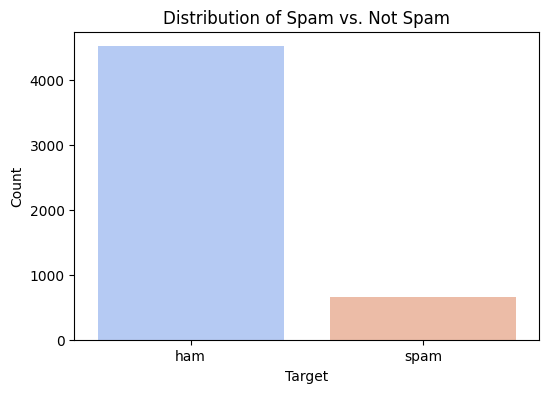

In [65]:
def plot_spam_distribution(data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Target', data=data, palette='coolwarm')
    plt.title('Distribution of Spam vs. Not Spam')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()
plot_spam_distribution(spam_data)

In [66]:
def pre_process_text(text):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'\W', ' ', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

In [67]:
pre_process_text('I\'m crazy for you')

'I crazy'

In [68]:
spam_data['Text'] = spam_data['Text'].apply(pre_process_text)

In [69]:
spam_data

,Target,Text
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I think go usf life around though
...,...,...
5567,spam,This 2nd time tried 2 contact u U å 750 Pound ...
5568,ham,Will Ì_ b going esplanade fr home
5569,ham,Pity mood So suggestion
5570,ham,The guy bitching I acted like interested buyin...


In [70]:
def num_words(sent):
    tokenized_words = nltk.word_tokenize(sent)
    return len(tokenized_words)

In [71]:
spam_data['Word_Count'] = spam_data['Text'].apply(num_words)

In [72]:
spam_data['Char_Count'] = spam_data['Text'].apply(lambda x : len(x.strip()))

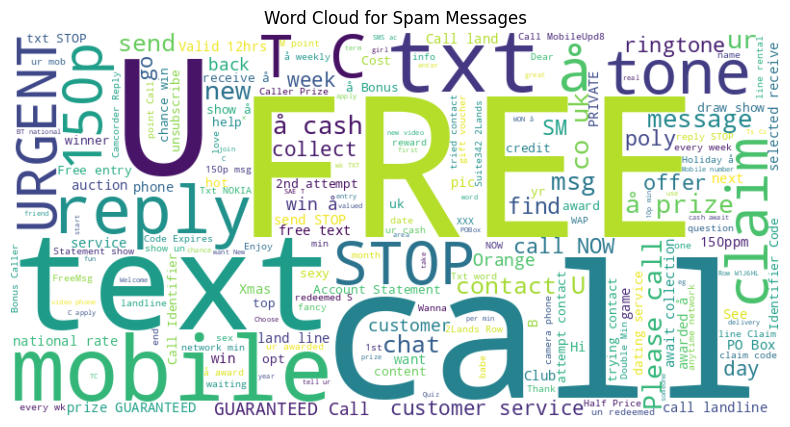

In [85]:
def plot_word_cloud(data):
    spam_text = ' '.join(data[data['Target'] == 'spam']['Text'])

    spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(spam_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Spam Messages')
    plt.axis('off')
    plt.show()
plot_word_cloud(spam_data)

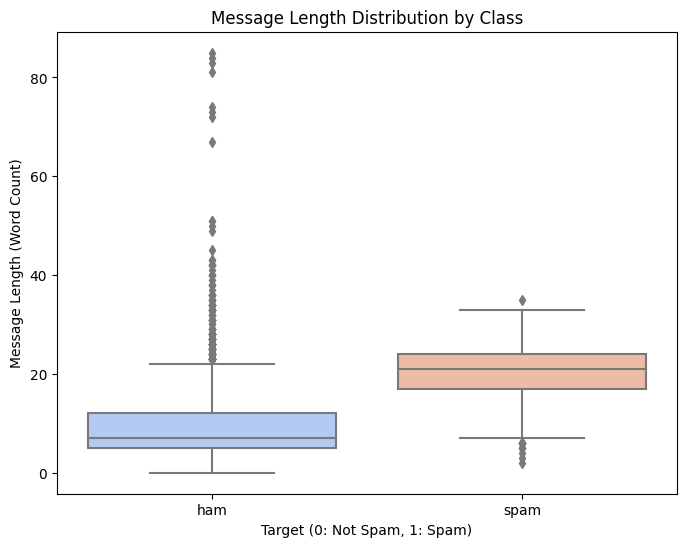

In [87]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Target', y='Word_Count', data=spam_data, palette='coolwarm')
plt.title('Message Length Distribution by Class')
plt.xlabel('Target (0: Not Spam, 1: Spam)')
plt.ylabel('Message Length (Word Count)')
plt.show()

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(spam_data['Text']).toarray()
y = spam_data['Target']

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [96]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.39%


In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       889
        spam       1.00      0.81      0.90       145

    accuracy                           0.97      1034
   macro avg       0.99      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



In [97]:
print(confusion_matrix(y_test, y_pred))

[[889   0]
 [ 27 118]]
